In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# LSTM

In [3]:
VOCAB_SIZE = 300
SEQ_LEN = 100

In [4]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
import torch
train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.long)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [6]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]


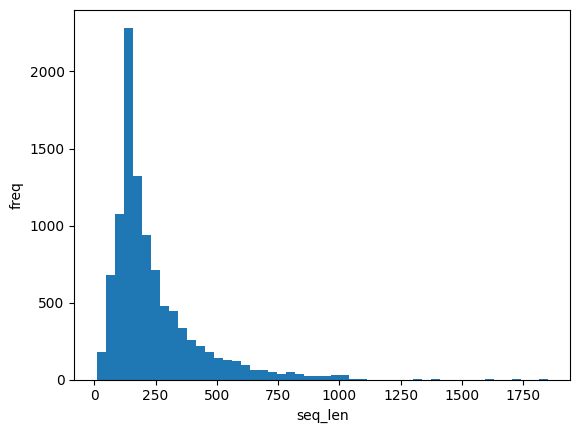

In [7]:
# 입력 데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [8]:
# padding 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
  padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [9]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

### 모델 준비 및 학습

### one-hot encoding + LSTM

In [14]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    _, (hidden, _) = self.lstm(x)
    out = self.fc(hidden[-1])
    return self.sigmoid(out)

In [15]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

print(lstm_model)

SentimentLSTM(
  (lstm): LSTM(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    # total_params += param.numel()
    print(f"{name:<20} {str(param.shape):<30} {param.numel()}")

print("=" * 60)
print(f'Total Trainable parameters: {total_params}')

Layer                Shape                          Params
lstm.weight_ih_l0    torch.Size([32, 300])          9600
lstm.weight_hh_l0    torch.Size([32, 8])            256
lstm.bias_ih_l0      torch.Size([32])               32
lstm.bias_hh_l0      torch.Size([32])               32
fc.weight            torch.Size([1, 8])             8
fc.bias              torch.Size([1])                1
Total Trainable parameters: 9929


Epoch 1/100 | Train Loss: 0.6934, Train Acc: 0.5104, Val Loss: 0.6922, Val Acc: 0.5185
Epoch 2/100 | Train Loss: 0.6849, Train Acc: 0.5593, Val Loss: 0.6957, Val Acc: 0.5180
Epoch 3/100 | Train Loss: 0.6807, Train Acc: 0.5736, Val Loss: 0.6868, Val Acc: 0.5440
Epoch 4/100 | Train Loss: 0.6673, Train Acc: 0.6090, Val Loss: 0.6625, Val Acc: 0.6015
Epoch 5/100 | Train Loss: 0.6612, Train Acc: 0.6055, Val Loss: 0.6869, Val Acc: 0.5415
Epoch 6/100 | Train Loss: 0.6726, Train Acc: 0.5933, Val Loss: 0.6869, Val Acc: 0.5450
Epoch 7/100 | Train Loss: 0.6453, Train Acc: 0.6309, Val Loss: 0.6588, Val Acc: 0.6120
Epoch 8/100 | Train Loss: 0.6742, Train Acc: 0.5745, Val Loss: 0.6872, Val Acc: 0.5360
Epoch 9/100 | Train Loss: 0.6710, Train Acc: 0.5890, Val Loss: 0.6851, Val Acc: 0.5490
Epoch 10/100 | Train Loss: 0.6605, Train Acc: 0.6038, Val Loss: 0.6842, Val Acc: 0.5555
Epoch 11/100 | Train Loss: 0.6310, Train Acc: 0.6440, Val Loss: 0.6415, Val Acc: 0.6480
Epoch 12/100 | Train Loss: 0.6026, Train 

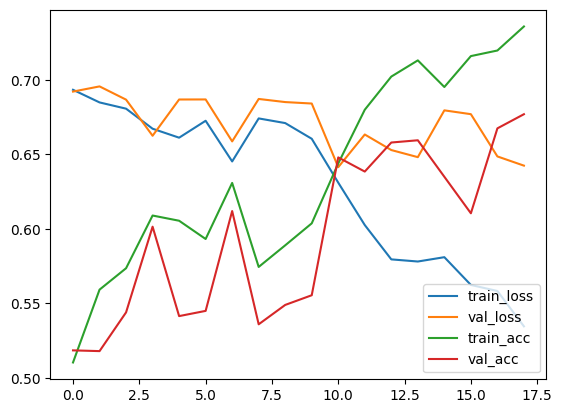

In [17]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 학습/검증셋 분할 + 미니배치 사용하도록 DataLoader 생성
train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.005)

# 시각화를 위한 손실값, 정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()               # 가중치 초기화
    outputs = lstm_model(inputs).squeeze()   # 순전파

    loss = criterion(outputs, targets)  # 손실 계산

    loss.backward()                     # 역전파
    optimizer.step()                    # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = lstm_model(val_inputs).squeeze()   # 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping!!!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()

In [18]:
def evaluate_model(model, test_loader, criterion):
  model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in test_loader:
      val_outputs = model(val_inputs).squeeze()   # 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  test_loss = val_loss / len(test_loader)
  test_acc = val_correct / val_total
  return test_loss, test_acc

In [19]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(lstm_model, test_loader, criterion)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.6136, Test Accuracy: 0.6902


### 모델 준비 및 학습

### Embedding + LSTM


In [25]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    x = self.embedding(x)
    _, (hidden, _) = self.lstm(x)
    out = self.fc(hidden[-1])
    return self.sigmoid(out)

In [26]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50

ebd_lstm_model = SentimentLSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

print(ebd_lstm_model)

SentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm): LSTM(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [28]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in ebd_lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    # total_params += param.numel()
    print(f"{name:<20} {str(param.shape):<30} {param.numel()}")

print("=" * 60)
print(f'Total Trainable parameters: {total_params}')

Layer                Shape                          Params
embedding.weight     torch.Size([300, 50])          15000
lstm.weight_ih_l0    torch.Size([32, 50])           1600
lstm.weight_hh_l0    torch.Size([32, 8])            256
lstm.bias_ih_l0      torch.Size([32])               32
lstm.bias_hh_l0      torch.Size([32])               32
fc.weight            torch.Size([1, 8])             8
fc.bias              torch.Size([1])                1
Total Trainable parameters: 16929


Epoch 1/100 | Train Loss: 0.4917, Train Acc: 0.7774, Val Loss: 0.4871, Val Acc: 0.7840
Epoch 2/100 | Train Loss: 0.4759, Train Acc: 0.7899, Val Loss: 0.4867, Val Acc: 0.7855
Epoch 3/100 | Train Loss: 0.4616, Train Acc: 0.7951, Val Loss: 0.4887, Val Acc: 0.7835
Epoch 4/100 | Train Loss: 0.4541, Train Acc: 0.8006, Val Loss: 0.4906, Val Acc: 0.7750
Epoch 5/100 | Train Loss: 0.4473, Train Acc: 0.8065, Val Loss: 0.4948, Val Acc: 0.7715
Epoch 6/100 | Train Loss: 0.4428, Train Acc: 0.8124, Val Loss: 0.4993, Val Acc: 0.7660
Epoch 7/100 | Train Loss: 0.4343, Train Acc: 0.8145, Val Loss: 0.5035, Val Acc: 0.7645
Epoch 8/100 | Train Loss: 0.4293, Train Acc: 0.8204, Val Loss: 0.5084, Val Acc: 0.7625
Epoch 9/100 | Train Loss: 0.4240, Train Acc: 0.8224, Val Loss: 0.5090, Val Acc: 0.7615
Early stopping!!!


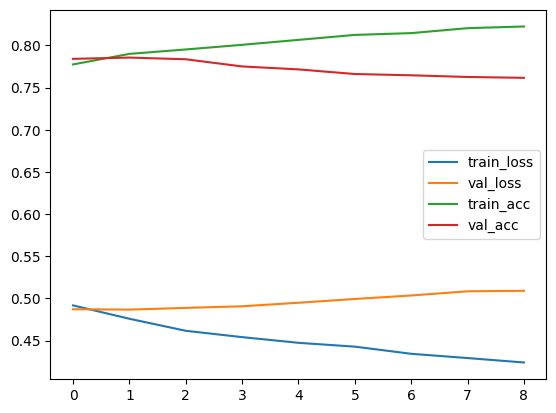

In [30]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_seq) * 0.8)
val_size = len(train_seq) - train_size

train_target = train_target.to(torch.float32)
train_dataset, val_dataset = random_split(TensorDataset(train_seq.to(torch.long), train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(ebd_lstm_model.parameters(), lr=0.001)

# 시각화를 위한 손실값, 정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  ebd_lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()               # 가중치 초기화
    outputs = ebd_lstm_model(inputs).squeeze()   # 순전파

    loss = criterion(outputs, targets)  # 손실 계산

    loss.backward()                     # 역전파
    optimizer.step()                    # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  ebd_lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = ebd_lstm_model(val_inputs).squeeze()   # 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping!!!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()

In [31]:
def evaluate_model(model, test_loader, criterion):
  model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in test_loader:
      val_outputs = model(val_inputs).squeeze()   # 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  test_loss = val_loss / len(test_loader)
  test_acc = val_correct / val_total
  return test_loss, test_acc

In [34]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.6865, Test Accuracy: 0.6810


### 입출력 shape

- return_sequences
- return_state
- Bidirectional LSTM/GRU

In [37]:
import numpy as np

B = 2   # batch_size
T = 5   # timestep (= sequence_len)
D = 10  # embedding_dim
U = 3   # unit(뉴런수)

x = np.random.randn(B, T, D)

##### return_sequences

- LSTM 다층 구조를 만들거나 다대다 구조의 출력이 필요한 시퀀스 예측/변환 작업에서 설정
  - False(기본값) : 마지막 Timestep의 output만 반환
  - True : 모든 Timestep의 output 반환

In [39]:
from tensorflow.keras import models, layers

def lstm(x, return_sequences=False):
  input = layers.Input(shape=(T,D))
  output = layers.LSTM(U, return_sequences=return_sequences)(input)
  model = models.Model(input, output)
  model.summary()
  return model.predict(x)

print(lstm(x, return_sequences=False).shape)
print(lstm(x, return_sequences=True).shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
(2, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 5, 3)                │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
(2, 5, 3)


In [41]:
def lstm2(x, return_state=False):
  input = layers.Input(shape=(T, D))
  output = layers.LSTM(U, return_state=return_state)(input)
  model = models.Model(input, output)
  model.summary()
  return model.predict(x)

print(lstm2(x, return_state=False).shape)
# print(lstm2(x, return_state=True).shape)

output, hidden_state, cell_state = lstm2(x, return_state=True)
print(output.shape, hidden_state.shape, cell_state.shape)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 3)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
(2, 3)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ [(None, 3), (None, 3),      │             168 │
│                                      │ (None, 3)]                  │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
(2, 3) (2, 3) (2, 3)


##### Bidirectional LSTM

In [44]:
def bi_lstm(x, return_sequences=False, return_state=False):
  input = layers.Input(shape=(T, D))
  lstm = layers.LSTM(U, return_sequences=return_sequences, return_state=return_state)
  output = layers.Bidirectional(lstm)(input)
  model = models.Model(inputs=input, outputs=output)
  model.summary()
  return model.predict(x)

output1 = bi_lstm(x)
print(output1.shape)

output2 = bi_lstm(x, return_sequences=True)
print(output2.shape)

output3, for_h_stt, for_c_stt, back_h_stt, back_c_stt = bi_lstm(x, return_state=True)
print(output3.shape, for_h_stt.shape, for_c_stt.shape, back_h_stt.shape, back_c_stt.shape)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 6)                   │             336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
(2, 6)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 5, 6)                │             336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
(2, 5, 6)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ [(None, 6), (None, 3),      │             336 │
│                                      │ (None, 3), (None, 3),       │                 │
│                                      │ (None, 3)]                  │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
(2, 6) (2, 3) (2, 3) (2, 3) (2, 3)
